In [1]:
%pip install -e ..

Obtaining file:///home/rstudio/rl4greencrab
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Installing backend dependencies ... done
  Preparing editable metadata (pyproject.toml) ... done
  Using cached gymnasium-1.1.1-py3-none-any.whl.metadata (9.4 kB)
  Using cached optuna-4.4.0-py3-none-any.whl.metadata (17 kB)
  Using cached sb3_contrib-2.6.0-py3-none-any.whl.metadata (4.1 kB)
  Using cached scikit_optimize-0.10.2-py2.py3-none-any.whl.metadata (9.7 kB)
  Using cached scikit_plot-0.3.7-py3-none-any.whl.metadata (7.1 kB)
  Using cached stable_baselines3-2.6.0-py3-none-any.whl.metadata (4.8 kB)
  Using cached typing-3.7.4.3-py3-none-any.whl
  Using cached Farama_Notifications-0.0.4-py3-none-any.whl.metadata (558 bytes)
  Using cached colorlog-6.9.0-py3-none-any.whl.metadata (10 kB)
  Using cached sympy-1.14.0-py3-none-any.whl.metadata (12 kB)
  Using cached nvidia_cuda_nvrtc_cu12

In [1]:
import numpy as np
import pandas as pd
from skopt import gp_minimize, gbrt_minimize 
from skopt.plots import plot_convergence, plot_objective
from rl4greencrab.envs.green_crab_monthly_env import greenCrabMonthEnv
from rl4greencrab.envs.green_crab_monthly_env_norm import greenCrabMonthEnvNormalized
from rl4greencrab.envs.green_crab_movingAvg import greenCrabMonthNormalizedMoving
from rl4greencrab import evaluate_agent, multiConstAction, simulator, environment_simulation, plot_selected_sizes
import matplotlib.pyplot as plt
from ipywidgets import interact, widgets
from huggingface_hub import hf_hub_download
from stable_baselines3 import PPO, TD3
from sb3_contrib import TQC, RecurrentPPO
from LipschitzPPO import LipschitzPPO

## Monthly Environment Simulation

In [105]:
config = {
    "w_mort_scale" : 600,
    "growth_k": 0.70,
    'random_start':True,
    'variance_penalty_ratio': 0.5
    # "curriculum": True
}

In [3]:
def evaluateConstAct(x):
    config = {
        "w_mort_scale" : 600,
        "growth_k": 0.70,
        'random_start':True,
        "curriculum": True
    }
    env = greenCrabMonthEnv(config)
    agent = multiConstAction(env=env, action=np.array(x))
    # rewards = simulator(env, agent).simulate()
    # out = np.mean(rewards)
    m_reward = evaluate_agent(agent=agent, ray_remote=True).evaluate(n_eval_episodes=200)
    
    return - m_reward

In [4]:
%%time
max_action = 3000
res = gp_minimize(evaluateConstAct, 3*[(0.0, max_action)], n_calls = 100, verbose=True)
res.x

Iteration No: 1 started. Evaluating function at random point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(
2025-06-28 05:01:53,933	INFO worker.py:1917 -- Started a local Ray instance.


Iteration No: 1 ended. Evaluation done at random point.
Time taken: 13.6230
Function value obtained: 13.6623
Current minimum: 13.6623
Iteration No: 2 started. Evaluating function at random point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.6189
Function value obtained: 26.7217
Current minimum: 13.6623
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.5093
Function value obtained: 48.9507
Current minimum: 13.6623
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.5949
Function value obtained: 17.3585
Current minimum: 13.6623
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 0.5668
Function value obtained: 41.8291
Current minimum: 13.6623
Iteration No: 6 started. Evaluating function at random point.
Iteration No: 6 ended. Evaluation done at random point.
Time taken: 0.5750
Function value obtained: 41.7397
Current minimum: 13.6623
Iteration No: 7 started. Evaluating function at random point.
Iteration No: 7 ended. Ev

/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 11 ended. Search finished for the next optimal point.
Time taken: 0.7082
Function value obtained: 12.7642
Current minimum: 12.7642
Iteration No: 12 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 12 ended. Search finished for the next optimal point.
Time taken: 0.8717
Function value obtained: 20.7151
Current minimum: 12.7642
Iteration No: 13 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 13 ended. Search finished for the next optimal point.
Time taken: 0.8308
Function value obtained: 7.5803
Current minimum: 7.5803
Iteration No: 14 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 0.7667
Function value obtained: 8.6176
Current minimum: 7.5803
Iteration No: 15 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 0.7794
Function value obtained: 7.6472
Current minimum: 7.5803
Iteration No: 16 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 1.0804
Function value obtained: 8.9268
Current minimum: 7.5803
Iteration No: 17 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 0.8994
Function value obtained: 7.5047
Current minimum: 7.5047
Iteration No: 18 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 0.9232
Function value obtained: 7.2393
Current minimum: 7.2393
Iteration No: 19 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 1.0315
Function value obtained: 10.5662
Current minimum: 7.2393
Iteration No: 20 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 1.0353
Function value obtained: 7.4960
Current minimum: 7.2393
Iteration No: 21 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 0.8695
Function value obtained: 7.3980
Current minimum: 7.2393
Iteration No: 22 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 0.8929
Function value obtained: 7.4014
Current minimum: 7.2393
Iteration No: 23 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 0.8642
Function value obtained: 7.4934
Current minimum: 7.2393
Iteration No: 24 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 0.8712
Function value obtained: 7.3783
Current minimum: 7.2393
Iteration No: 25 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 0.9177
Function value obtained: 7.3392
Current minimum: 7.2393
Iteration No: 26 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 0.9677
Function value obtained: 7.1085
Current minimum: 7.1085
Iteration No: 27 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 1.0311
Function value obtained: 7.4609
Current minimum: 7.1085
Iteration No: 28 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 0.9584
Function value obtained: 7.4073
Current minimum: 7.1085
Iteration No: 29 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 0.8810
Function value obtained: 7.2634
Current minimum: 7.1085
Iteration No: 30 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 0.8920
Function value obtained: 7.2798
Current minimum: 7.1085
Iteration No: 31 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 31 ended. Search finished for the next optimal point.
Time taken: 0.9466
Function value obtained: 7.4204
Current minimum: 7.1085
Iteration No: 32 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 32 ended. Search finished for the next optimal point.
Time taken: 0.9880
Function value obtained: 7.5031
Current minimum: 7.1085
Iteration No: 33 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 33 ended. Search finished for the next optimal point.
Time taken: 1.0844
Function value obtained: 7.1882
Current minimum: 7.1085
Iteration No: 34 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 34 ended. Search finished for the next optimal point.
Time taken: 1.2356
Function value obtained: 7.2645
Current minimum: 7.1085
Iteration No: 35 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 35 ended. Search finished for the next optimal point.
Time taken: 1.2211
Function value obtained: 7.4097
Current minimum: 7.1085
Iteration No: 36 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 36 ended. Search finished for the next optimal point.
Time taken: 0.9389
Function value obtained: 7.5075
Current minimum: 7.1085
Iteration No: 37 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 37 ended. Search finished for the next optimal point.
Time taken: 1.2060
Function value obtained: 7.2743
Current minimum: 7.1085
Iteration No: 38 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 38 ended. Search finished for the next optimal point.
Time taken: 1.5373
Function value obtained: 7.4898
Current minimum: 7.1085
Iteration No: 39 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 39 ended. Search finished for the next optimal point.
Time taken: 1.2039
Function value obtained: 7.3248
Current minimum: 7.1085
Iteration No: 40 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 40 ended. Search finished for the next optimal point.
Time taken: 1.3572
Function value obtained: 7.3203
Current minimum: 7.1085
Iteration No: 41 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 41 ended. Search finished for the next optimal point.
Time taken: 1.1958
Function value obtained: 7.5148
Current minimum: 7.1085
Iteration No: 42 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 42 ended. Search finished for the next optimal point.
Time taken: 1.3091
Function value obtained: 7.5679
Current minimum: 7.1085
Iteration No: 43 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 43 ended. Search finished for the next optimal point.
Time taken: 1.2192
Function value obtained: 7.5160
Current minimum: 7.1085
Iteration No: 44 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 44 ended. Search finished for the next optimal point.
Time taken: 1.3348
Function value obtained: 7.3708
Current minimum: 7.1085
Iteration No: 45 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 45 ended. Search finished for the next optimal point.
Time taken: 1.3879
Function value obtained: 7.5369
Current minimum: 7.1085
Iteration No: 46 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 46 ended. Search finished for the next optimal point.
Time taken: 1.3026
Function value obtained: 7.4287
Current minimum: 7.1085
Iteration No: 47 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 47 ended. Search finished for the next optimal point.
Time taken: 1.5216
Function value obtained: 7.2046
Current minimum: 7.1085
Iteration No: 48 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 48 ended. Search finished for the next optimal point.
Time taken: 1.7031
Function value obtained: 7.4190
Current minimum: 7.1085
Iteration No: 49 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 49 ended. Search finished for the next optimal point.
Time taken: 1.8783
Function value obtained: 7.3788
Current minimum: 7.1085
Iteration No: 50 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 50 ended. Search finished for the next optimal point.
Time taken: 1.5685
Function value obtained: 7.3796
Current minimum: 7.1085
Iteration No: 51 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 51 ended. Search finished for the next optimal point.
Time taken: 1.7122
Function value obtained: 7.7262
Current minimum: 7.1085
Iteration No: 52 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 52 ended. Search finished for the next optimal point.
Time taken: 1.4370
Function value obtained: 7.2970
Current minimum: 7.1085
Iteration No: 53 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 53 ended. Search finished for the next optimal point.
Time taken: 1.5944
Function value obtained: 7.4854
Current minimum: 7.1085
Iteration No: 54 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 54 ended. Search finished for the next optimal point.
Time taken: 2.3566
Function value obtained: 7.4444
Current minimum: 7.1085
Iteration No: 55 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 55 ended. Search finished for the next optimal point.
Time taken: 2.2118
Function value obtained: 7.4328
Current minimum: 7.1085
Iteration No: 56 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 56 ended. Search finished for the next optimal point.
Time taken: 1.7018
Function value obtained: 7.5285
Current minimum: 7.1085
Iteration No: 57 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 57 ended. Search finished for the next optimal point.
Time taken: 1.8438
Function value obtained: 7.5619
Current minimum: 7.1085
Iteration No: 58 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 58 ended. Search finished for the next optimal point.
Time taken: 1.7499
Function value obtained: 7.2951
Current minimum: 7.1085
Iteration No: 59 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 59 ended. Search finished for the next optimal point.
Time taken: 2.0695
Function value obtained: 7.3659
Current minimum: 7.1085
Iteration No: 60 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 60 ended. Search finished for the next optimal point.
Time taken: 1.9940
Function value obtained: 7.4677
Current minimum: 7.1085
Iteration No: 61 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 61 ended. Search finished for the next optimal point.
Time taken: 2.0405
Function value obtained: 7.3584
Current minimum: 7.1085
Iteration No: 62 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 62 ended. Search finished for the next optimal point.
Time taken: 1.9773
Function value obtained: 7.3290
Current minimum: 7.1085
Iteration No: 63 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 63 ended. Search finished for the next optimal point.
Time taken: 1.9538
Function value obtained: 7.4251
Current minimum: 7.1085
Iteration No: 64 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 64 ended. Search finished for the next optimal point.
Time taken: 1.7565
Function value obtained: 7.3212
Current minimum: 7.1085
Iteration No: 65 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 65 ended. Search finished for the next optimal point.
Time taken: 1.7890
Function value obtained: 7.3517
Current minimum: 7.1085
Iteration No: 66 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 66 ended. Search finished for the next optimal point.
Time taken: 2.2077
Function value obtained: 7.4228
Current minimum: 7.1085
Iteration No: 67 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 67 ended. Search finished for the next optimal point.
Time taken: 4.2847
Function value obtained: 7.4944
Current minimum: 7.1085
Iteration No: 68 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 68 ended. Search finished for the next optimal point.
Time taken: 2.1360
Function value obtained: 7.3237
Current minimum: 7.1085
Iteration No: 69 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 69 ended. Search finished for the next optimal point.
Time taken: 2.0477
Function value obtained: 7.5125
Current minimum: 7.1085
Iteration No: 70 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 70 ended. Search finished for the next optimal point.
Time taken: 2.1177
Function value obtained: 7.4174
Current minimum: 7.1085
Iteration No: 71 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 71 ended. Search finished for the next optimal point.
Time taken: 2.1132
Function value obtained: 7.3886
Current minimum: 7.1085
Iteration No: 72 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 72 ended. Search finished for the next optimal point.
Time taken: 2.1693
Function value obtained: 7.3658
Current minimum: 7.1085
Iteration No: 73 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 73 ended. Search finished for the next optimal point.
Time taken: 2.3150
Function value obtained: 7.5835
Current minimum: 7.1085
Iteration No: 74 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 74 ended. Search finished for the next optimal point.
Time taken: 1.9455
Function value obtained: 7.3298
Current minimum: 7.1085
Iteration No: 75 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 75 ended. Search finished for the next optimal point.
Time taken: 2.2961
Function value obtained: 7.4131
Current minimum: 7.1085
Iteration No: 76 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 76 ended. Search finished for the next optimal point.
Time taken: 3.9715
Function value obtained: 7.4659
Current minimum: 7.1085
Iteration No: 77 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 77 ended. Search finished for the next optimal point.
Time taken: 2.2057
Function value obtained: 7.4189
Current minimum: 7.1085
Iteration No: 78 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 78 ended. Search finished for the next optimal point.
Time taken: 2.4058
Function value obtained: 7.4758
Current minimum: 7.1085
Iteration No: 79 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 79 ended. Search finished for the next optimal point.
Time taken: 2.4013
Function value obtained: 7.5130
Current minimum: 7.1085
Iteration No: 80 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 80 ended. Search finished for the next optimal point.
Time taken: 2.6404
Function value obtained: 7.2841
Current minimum: 7.1085
Iteration No: 81 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 81 ended. Search finished for the next optimal point.
Time taken: 2.2173
Function value obtained: 7.2551
Current minimum: 7.1085
Iteration No: 82 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 82 ended. Search finished for the next optimal point.
Time taken: 2.7485
Function value obtained: 7.4379
Current minimum: 7.1085
Iteration No: 83 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 83 ended. Search finished for the next optimal point.
Time taken: 6.0495
Function value obtained: 7.4557
Current minimum: 7.1085
Iteration No: 84 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 84 ended. Search finished for the next optimal point.
Time taken: 3.1480
Function value obtained: 7.2858
Current minimum: 7.1085
Iteration No: 85 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 85 ended. Search finished for the next optimal point.
Time taken: 2.6453
Function value obtained: 7.4054
Current minimum: 7.1085
Iteration No: 86 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 86 ended. Search finished for the next optimal point.
Time taken: 2.9981
Function value obtained: 7.2867
Current minimum: 7.1085
Iteration No: 87 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 87 ended. Search finished for the next optimal point.
Time taken: 3.1513
Function value obtained: 7.4162
Current minimum: 7.1085
Iteration No: 88 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 88 ended. Search finished for the next optimal point.
Time taken: 3.2841
Function value obtained: 7.3648
Current minimum: 7.1085
Iteration No: 89 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 89 ended. Search finished for the next optimal point.
Time taken: 3.1545
Function value obtained: 7.4189
Current minimum: 7.1085
Iteration No: 90 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 90 ended. Search finished for the next optimal point.
Time taken: 2.9282
Function value obtained: 7.4457
Current minimum: 7.1085
Iteration No: 91 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 91 ended. Search finished for the next optimal point.
Time taken: 3.7223
Function value obtained: 7.4371
Current minimum: 7.1085
Iteration No: 92 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 92 ended. Search finished for the next optimal point.
Time taken: 3.4192
Function value obtained: 7.4391
Current minimum: 7.1085
Iteration No: 93 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 93 ended. Search finished for the next optimal point.
Time taken: 2.8799
Function value obtained: 7.3252
Current minimum: 7.1085
Iteration No: 94 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 94 ended. Search finished for the next optimal point.
Time taken: 2.7531
Function value obtained: 7.4955
Current minimum: 7.1085
Iteration No: 95 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 95 ended. Search finished for the next optimal point.
Time taken: 2.9264
Function value obtained: 7.5656
Current minimum: 7.1085
Iteration No: 96 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 96 ended. Search finished for the next optimal point.
Time taken: 3.3102
Function value obtained: 7.3765
Current minimum: 7.1085
Iteration No: 97 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 97 ended. Search finished for the next optimal point.
Time taken: 3.2007
Function value obtained: 7.2573
Current minimum: 7.1085
Iteration No: 98 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 98 ended. Search finished for the next optimal point.
Time taken: 4.1834
Function value obtained: 7.4001
Current minimum: 7.1085
Iteration No: 99 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 99 ended. Search finished for the next optimal point.
Time taken: 3.0363
Function value obtained: 7.3758
Current minimum: 7.1085
Iteration No: 100 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 100 ended. Search finished for the next optimal point.
Time taken: 3.5538
Function value obtained: 7.3085
Current minimum: 7.1085
CPU times: user 1h 42min 44s, sys: 19.6 s, total: 1h 43min 4s
Wall time: 3min 14s


[2037.5353870577821, 0.0, 0.0]

In [6]:
# with nonNormalized env
evaluateConstAct(
    [234.1763524346601, 943.2079115173758, 0.0]
)

6.463141914905166

In [7]:
import ray
ray.shutdown()

In [8]:
env = greenCrabMonthEnv(config)
agent = multiConstAction(env=env, action=np.array([234.1763524346601, 943.2079115173758, 0.0]))
constantData = simulator(env = env, agent = agent).simulate_full_named_dict_obs_acts()
constantDataDF = pd.DataFrame(constantData)

<Axes: xlabel='t'>

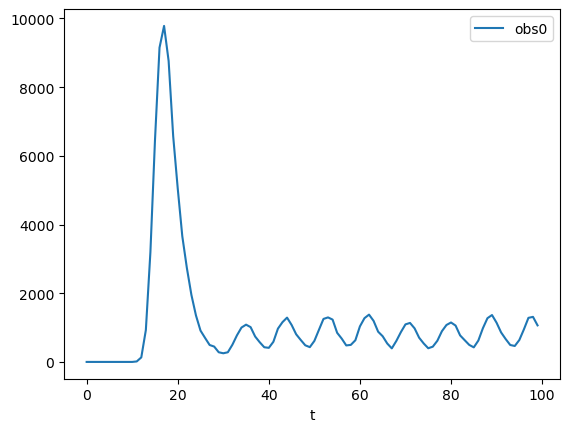

In [9]:
constantDataDF[constantDataDF.rep == 0].plot(x='t', y =['obs0'])

### normalized environment

In [10]:
config = {
    "w_mort_scale" : 600,
    "growth_k": 0.70,
    'random_start':True,
    # "curriculum": True
}

In [11]:
env = greenCrabMonthEnvNormalized(config)

/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


In [12]:
def evaluateConstAct(x):
    env = greenCrabMonthEnvNormalized(config)
    agent = multiConstAction(env=env, action=np.array(x))
    # rewards = simulator(env, agent).simulate()
    # out = np.mean(rewards)
    rewards = evaluate_agent(agent=agent, ray_remote=True).evaluate(n_eval_episodes=200, return_episode_rewards=True)
    m_reward = np.mean(rewards)
    return -m_reward, rewards

In [13]:
# normalized constant action
def normalized_action(act, max_act):
    max_action = max_act
    constant_act = np.array(act)
    return constant_act * 2 / max_action - 1 

In [14]:
norm_act = normalized_action([234.1763524346601, 943.2079115173758, 0.0], 3000)
m_reward, const_rews = evaluateConstAct(norm_act)
np.mean(const_rews)

2025-06-28 05:07:11,256	INFO worker.py:1917 -- Started a local Ray instance.


-6.4107162780829094

In [15]:
import ray
ray.shutdown()

In [17]:
agent = multiConstAction(env=env, action=np.array(norm_act))

In [16]:
constantData = simulator(env = env, agent = agent).simulate_full_named_dict_obs_acts()
constantDataDF = pd.DataFrame(constantData)

<Axes: xlabel='t'>

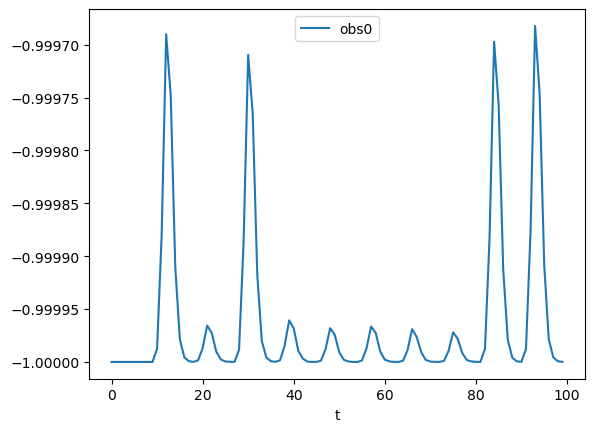

In [17]:
constantDataDF[constantDataDF.rep == 0].plot(x='t', y =['obs0'])

## Loading and evaluating trained models

In [52]:
repo_id = "jimjiang203/greencrabPPO"
td3_path = hf_hub_download(repo_id=repo_id, filename='td3_gcmonthnorm.zip')
ppo_path = hf_hub_download(repo_id=repo_id, filename='PPO_gcmenorm.zip')
reppo_path = hf_hub_download(repo_id=repo_id, filename='RecurrentPPO_gcmenorm.zip')
tqc_path = hf_hub_download(repo_id=repo_id, filename='TQC_gcmenorm.zip')

In [148]:
config = {
    "w_mort_scale" : 600,
    "growth_k": 0.70,
    'random_start':True,
    'var_penalty_const': 0.3
    # "curriculum": True
}

In [149]:
evalEnv =  greenCrabMonthEnvNormalized(config)

In [150]:
path = "../saved_agents"
td3Agent = TD3.load(f"TD3_gcmenorm_0", device="cpu")
ppoAgent = PPO.load(f"PPO_gcmenorm_0", device="cpu")
tqcAgent = TQC.load(f"TQC_gcmenorm_0", device="cpu")
recurrentPPOAgent = RecurrentPPO.load("RecurrentPPO_gcmenorm_256_1_{'pi': [256, 256], 'vf': [256, 256]}_False", device="cpu")
lppoAgent = LipschitzPPO.load("LipschitzPPO_gcmemoving_0.1_0.5", device="cpu")

In [151]:
N_EPS = 30

ppo_rew = evaluate_agent(agent=ppoAgent, env=evalEnv, ray_remote=True).evaluate(n_eval_episodes=N_EPS)
td3_rew = evaluate_agent(agent=td3Agent, env=evalEnv, ray_remote=True).evaluate(n_eval_episodes=N_EPS)
tqc_rew = evaluate_agent(agent=tqcAgent, env=evalEnv, ray_remote=True).evaluate(n_eval_episodes=N_EPS)
reppo_rew = evaluate_agent(agent=recurrentPPOAgent, env=evalEnv, ray_remote=True).evaluate(n_eval_episodes=N_EPS)
lppo_rew = evaluate_agent(agent=lppoAgent, env=evalEnv, ray_remote=True).evaluate(n_eval_episodes=N_EPS)

2025-06-30 23:27:00,414	INFO worker.py:1917 -- Started a local Ray instance.


In [152]:
N_EPS = 200

ppo_rews = evaluate_agent(agent=ppoAgent, env=evalEnv, ray_remote=True).evaluate(n_eval_episodes=N_EPS, return_episode_rewards=True)
td3_rews = evaluate_agent(agent=td3Agent, env=evalEnv, ray_remote=True).evaluate(n_eval_episodes=N_EPS, return_episode_rewards=True)
tqc_rews = evaluate_agent(agent=tqcAgent, env=evalEnv, ray_remote=True).evaluate(n_eval_episodes=N_EPS, return_episode_rewards=True)
reppo_rews = evaluate_agent(agent=recurrentPPOAgent, env=evalEnv, ray_remote=True).evaluate(n_eval_episodes=N_EPS, return_episode_rewards=True)
lppo_rews = evaluate_agent(agent=lppoAgent, env=evalEnv, ray_remote=True).evaluate(n_eval_episodes=N_EPS, return_episode_rewards=True)

In [153]:
import ray
ray.shutdown()

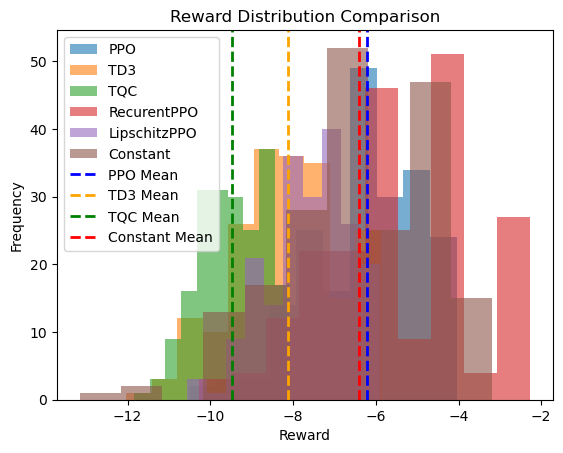

In [154]:
plt.hist(ppo_rews, alpha=0.6, label='PPO')
plt.hist(td3_rews, alpha=0.6, label='TD3')
plt.hist(tqc_rews, alpha=0.6, label='TQC')
plt.hist(reppo_rews , alpha=0.6, label='RecurentPPO')
plt.hist(lppo_rews , alpha=0.6, label='LipschitzPPO')
plt.hist(const_rews, alpha=0.6, label='Constant')

# # Mark means with vertical lines
plt.axvline(np.mean(ppo_rews), color='blue', linestyle='dashed', linewidth=2, label='PPO Mean')
plt.axvline(np.mean(td3_rews), color='orange', linestyle='dashed', linewidth=2, label='TD3 Mean')
plt.axvline(np.mean(tqc_rews), color='green', linestyle='dashed', linewidth=2, label='TQC Mean')
plt.axvline(np.mean(const_rews), color='red', linestyle='dashed', linewidth=2, label='Constant Mean')

plt.legend()
plt.xlabel("Reward")
plt.ylabel("Frequency")
plt.title("Reward Distribution Comparison")
plt.show()

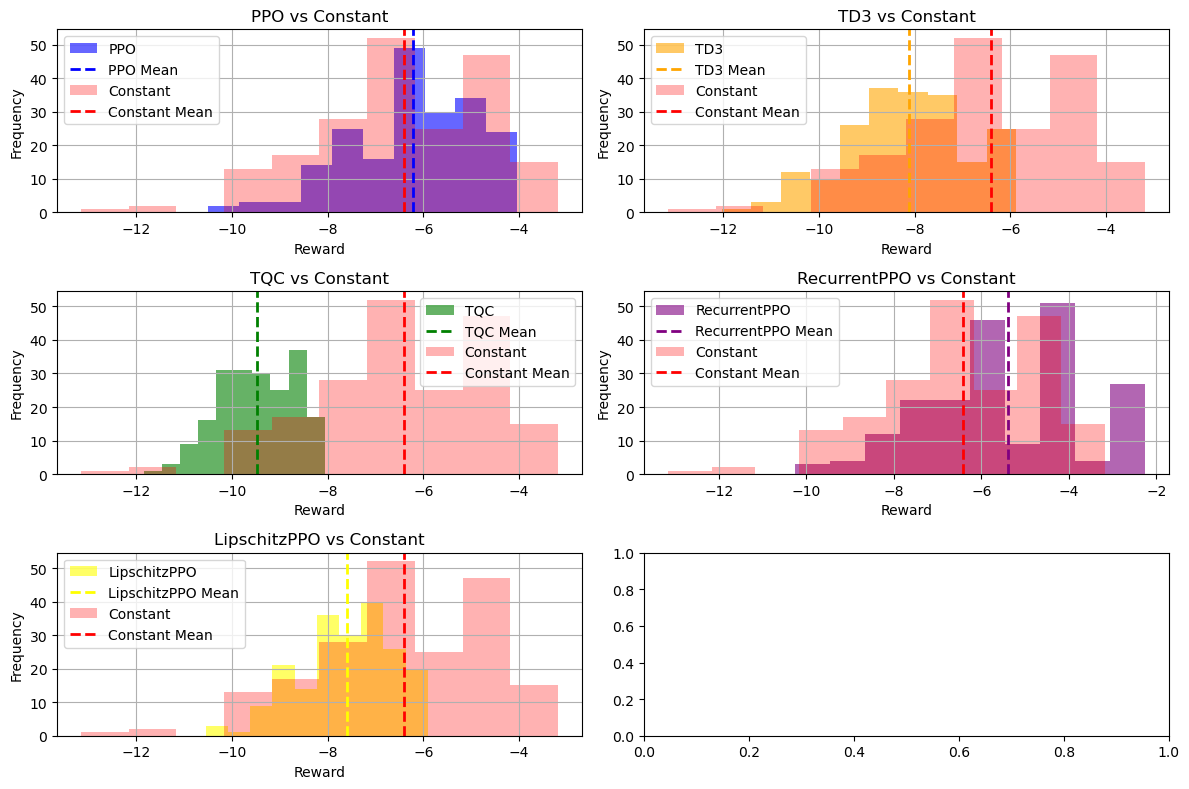

In [155]:
models = {
    'PPO': ppo_rews,
    'TD3': td3_rews,
    'TQC': tqc_rews,
    'RecurrentPPO': reppo_rews,
    'LipschitzPPO': lppo_rews
}
constant_rewards = const_rews

colors = {
    'PPO': 'blue',
    'TD3': 'orange',
    'TQC': 'green',
    'RecurrentPPO': 'purple',
    'LipschitzPPO': 'yellow',
    'Constant': 'red'
}

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 8))
axes = axes.flatten()

for i, (model_name, rewards) in enumerate(models.items()):
    ax = axes[i]
    # Plot current model
    ax.hist(rewards, alpha=0.6, color=colors[model_name], label=model_name)
    ax.axvline(np.mean(rewards), color=colors[model_name], linestyle='dashed', linewidth=2, label=f'{model_name} Mean')

    # Plot constant model
    ax.hist(constant_rewards, alpha=0.3, color=colors['Constant'], label='Constant')
    ax.axvline(np.mean(constant_rewards), color=colors['Constant'], linestyle='dashed', linewidth=2, label='Constant Mean')

    ax.set_title(f"{model_name} vs Constant")
    ax.set_xlabel("Reward")
    ax.set_ylabel("Frequency")
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()

In [156]:
np.std(ppo_rews), np.std(td3_rews), np.std(tqc_rews), np.std(reppo_rews)

(1.3618707748596848,
 1.3108740027743142,
 0.7856916393834003,
 1.8498472573940548)

In [157]:
np.mean(ppo_rews), np.mean(td3_rews), np.mean(tqc_rews), np.mean(reppo_rews), np.mean(lppo_rew)

(-6.212789627877283,
 -8.129595782300083,
 -9.474478115099632,
 -5.392525528600575,
 -7.605921329121122)

In [158]:
print(f"""
PPO mean rew = {ppo_rew}
TQC mean rew = {tqc_rew}
TD3 mean rew = {td3_rew}
RecurrentPPO mean rew = {reppo_rew}
LipschitzPPO mean rew = {lppo_rew}
""")


PPO mean rew = -6.498287184963784
TQC mean rew = -9.397032044375605
TD3 mean rew = -7.9587057268392645
RecurrentPPO mean rew = -5.80320063070276
LipschitzPPO mean rew = -7.605921329121122



### RL action plots

In [51]:
evalEnv =  greenCrabMonthEnvNormalized(config)

In [164]:
def agent_action_plot(evalEnv, agent, action=[]):
    data = simulator(env=evalEnv, agent=agent).simulate_full_named_dict_obs_acts()
    df = pd.DataFrame(data)

    # Line plots (separate)
    df[df.rep == 0].plot(x='t', y=['act0', 'act1', 'act2'], title="Actions over Time")
    df[df.rep == 0].plot(x='t', y=['obs0'], title="Observation 0 over Time")

    # Combined scatter plot (in one figure)
    fig, ax = plt.subplots()
    ax.scatter(x=df[df.rep == 0]['obs0'], y=df[df.rep == 0]['act0'], label='act1 vs obs0', alpha=0.7)
    ax.scatter(x=df[df.rep == 0]['obs0'], y=df[df.rep == 0]['act1'], label='act0 vs obs0', alpha=0.7)
    ax.scatter(x=df[df.rep == 0]['obs0'], y=df[df.rep == 0]['act2'], label='act0 vs obs0', alpha=0.7)
    ax.set_xlabel('Observation 0')
    ax.set_ylabel('Action')
    ax.set_title('Scatter Plots: act0/act1 vs obs0')
    ax.legend()
    
    plt.show()
    return df

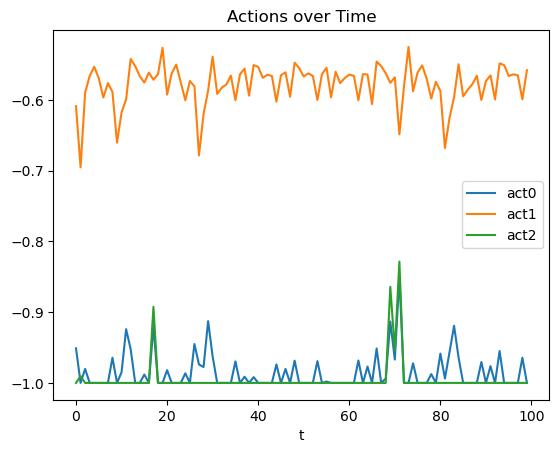

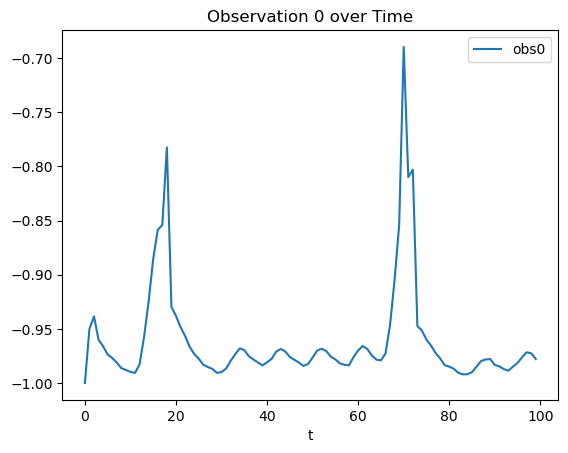

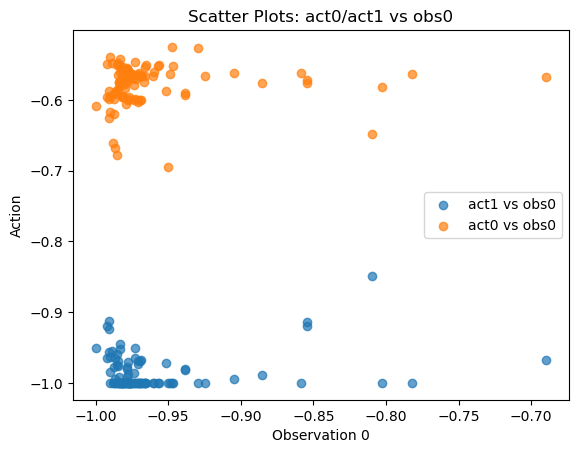

In [90]:
recurrentppoDataDF = agent_action_plot(evalEnv=evalEnv, agent=recurrentPPOAgent)

In [165]:
ppoAgent = PPO.load(f"PPO_gcmenorm_0", device="cpu")

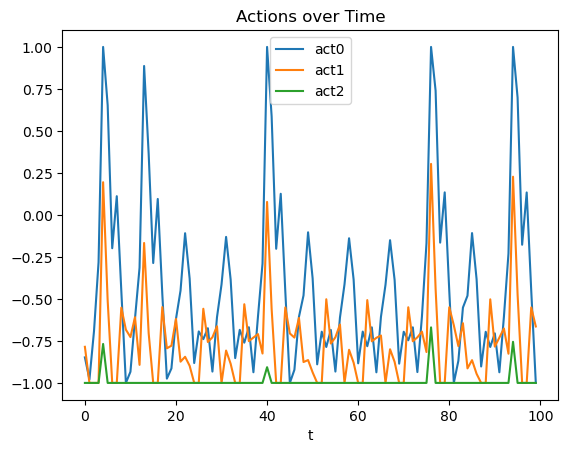

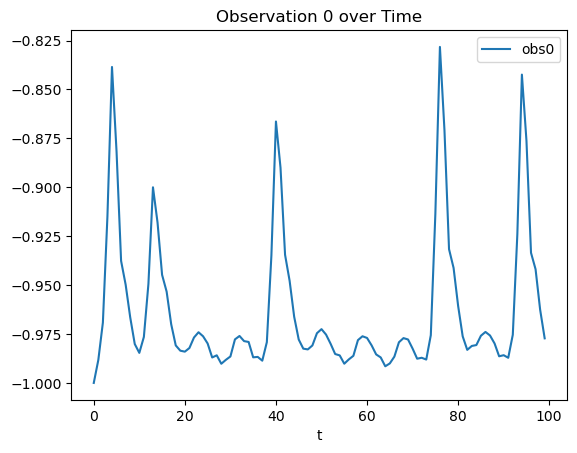

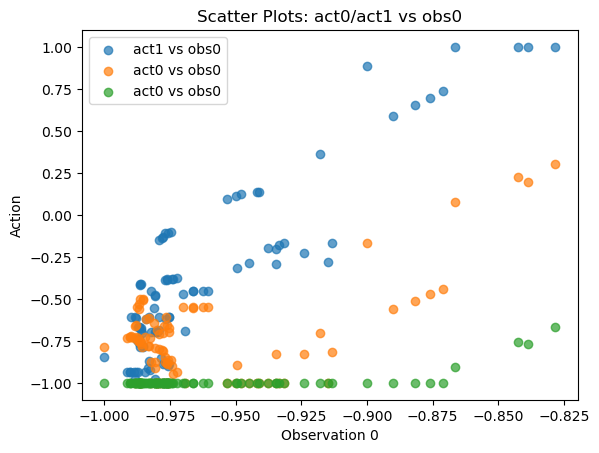

In [166]:
ppoDataDF = agent_action_plot(evalEnv=evalEnv, agent=ppoAgent)

<Axes: xlabel='t'>

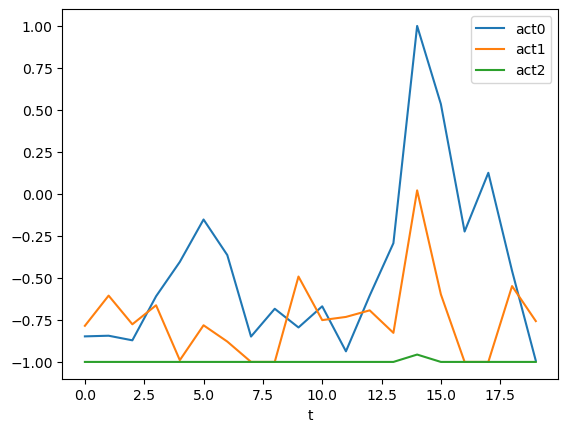

In [68]:
ppoDataDF[ppoDataDF.rep == 0].head(20).plot(x='t', y =['act0', 'act1', 'act2'])

## Special Section: Testing ensemble PPO

In [9]:
from ensemble_ppo import *

In [56]:
eppoAgent = EnsemblePPO.load('ensemblePPO_gcmenorm')

Loading ensemblePPO_gcmenorm/model_1.zip …


In [57]:
obs = {
    "crabs": np.array([1, 1]),
    "months" : 4 
}
eppoAgent.predict(obs)

(array([-0.03874406,  0.3987172 ,  1.        ], dtype=float32), None)

In [58]:
N_EPS = 30
eppo_rews = evaluate_agent(agent=eppoAgent, env=evalEnv, ray_remote=True).evaluate(n_eval_episodes=N_EPS, return_episode_rewards=True)

2025-06-16 18:37:01,363	INFO worker.py:1888 -- Started a local Ray instance.


In [59]:
import ray
ray.shutdown()

In [60]:
np.mean(eppo_rews)

-2.4034102689903323

In [61]:
ppoData = simulator(env = evalEnv, agent = eppoAgent).simulate_full_named_dict_obs_acts()
ppoDataDF = pd.DataFrame(ppoData)
ppoDataDF.head()

,t,obs0,obs1,act0,act1,act2,rew,rep
0,0,-1.000000,-1.000000,-0.974713,-0.849815,-1.0,0.000000,0
1,1,-0.979864,0.376640,-1.000000,1.000000,-1.0,-0.011415,0
2,2,-0.979767,-0.416228,-0.637097,-0.391289,-1.0,-0.092169,0
3,3,-0.983821,-0.119736,-1.000000,-1.000000,-1.0,-0.131576,0
4,4,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.132317,0


<Axes: xlabel='t'>

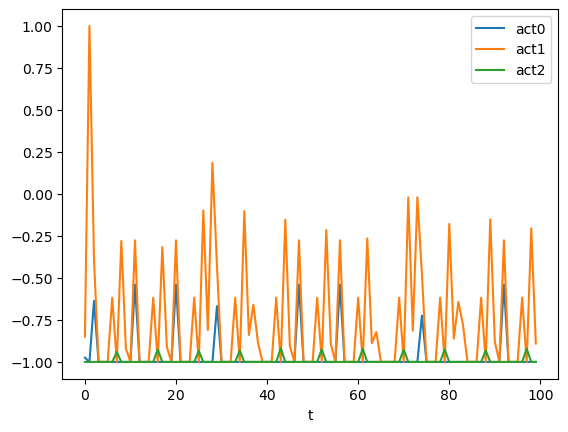

In [62]:
ppoDataDF[ppoDataDF.rep == 0].plot(x='t', y =['act0', 'act1', 'act2'])